**This notebook focuses on the effectiveness of Total Variance Minimization against adversarial attacks on the MNIST dataset.**

## **Section 0 - Setting Up**

### **Load prerequisites**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout, Layer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from art import config
from art.attacks.evasion import FastGradientMethod, DeepFool, ProjectedGradientDescent, SaliencyMapMethod, CarliniL2Method, NewtonFool, BasicIterativeMethod
from art.defences.preprocessor import TotalVarMin
from art.defences.trainer import AdversarialTrainer
from art.estimators.classification import KerasClassifier
from art.utils import load_mnist

### **Disable eager execution to enable adversarial crafting and ART classifier**

In [2]:
tf.compat.v1.disable_eager_execution()

### **Load MNIST dataset**

In [3]:
(x_train_cln, y_train_cln), (x_test_cln, y_test_cln), min_pixel_value, max_pixel_value = load_mnist()
# x_test_cln, y_test_cln = x_test_cln[:50], y_test_cln[:50]

### **Create MNIST classifier model**

*Load MNIST pre-trained model*

In [4]:
# model = load_model("/home/cyber/mnist_trained_model.h5")
model = load_model("/Users/Adrian/Downloads/Sem 3.2/Models & Checkpoints/mnist_trained_model.h5")

*Create ART classifier*

In [5]:
classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

## **Section 1 - Attack**

Step 1: Evaluate the classifier on the clean test set

In [6]:
predictions_cln = classifier.predict(x_test_cln)
accuracy_cln = np.sum(np.argmax(predictions_cln, axis=1) == np.argmax(y_test_cln, axis=1)) / len(y_test_cln)

print("Accuracy on clean test examples: {}%".format(accuracy_cln * 100))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Accuracy on clean test examples: 99.11%


Step 2: Split clean test examples into true and false positives

In [7]:
tp_cln_indexes=[]
fp_cln_indexes=[]
x_test_cln_tp=[]
y_test_cln_tp=[]
x_test_cln_fp=[]
y_test_cln_fp=[]

for k in range(len(predictions_cln)):
    if(np.argmax(predictions_cln, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k]):
        tp_cln_indexes.append(k)
    else:
        fp_cln_indexes.append(k)

for k in tp_cln_indexes:
    x_test_cln_tp.append(x_test_cln[k])
    y_test_cln_tp.append(y_test_cln[k])
    
for k in fp_cln_indexes:
    x_test_cln_fp.append(x_test_cln[k])
    y_test_cln_fp.append(y_test_cln[k])
    
x_test_cln_tp = np.array(x_test_cln_tp)
x_test_cln_fp = np.array(x_test_cln_fp)

print('Number of clean true positives: {:}'.format(len(x_test_cln_tp)))
print('Number of clean false positives: {:}'.format(len(x_test_cln_fp)))

Number of clean true positives: 9911
Number of clean false positives: 89


Step 3: Craft adversarial examples

*Craft Jacobian-based Saliency Map Attack (JSMA) attacks*

In [8]:
# attack = SaliencyMapMethod(classifier=classifier, theta = 0.1, gamma=0.3, verbose=True)
# x_test_JSMA_MNIST = attack.generate(x_test_cln)
# %store x_test_JSMA_MNIST

*Craft Basic Iterative Method (BMI) attacks*

In [9]:
# attack = BasicIterativeMethod(classifier, eps=0.3, eps_step=0.1, max_iter=50)
# x_test_BIM_MNIST = attack.generate(x_test_cln)
# %store x_test_BIM_MNSIT

*Craft Projected Gradient Descent (PGD) attacks*

In [10]:
# attack = ProjectedGradientDescent(classifier, eps=0.3, eps_step=0.1, max_iter=100)
# x_test_PGD_MNIST = attack.generate(x_test_cln)
# %store x_test_PGD_MNIST

*Craft NewtonFool attacks*

In [11]:
# attack =  NewtonFool(classifier=classifier, eta=3, max_iter=300, verbose=True)
# x_test_Newton_MNIST = attack.generate(x_test_cln[:100])
# # %store x_test_Newton_MNIST

*Craft DeepFool attacks*

In [12]:
# attack = DeepFool(classifier=classifier, epsilon=1e-06, max_iter=100)
# x_test_Deep_MNIST = attack.generate(x_test_cln)
# %store x_test_Deep_MNIST

*Alternatively, load existing adversarial attacks*

In [245]:
attack_name = 'DeepFool'
%store -r x_test_Deep_MNIST
x_test_adv = x_test_Deep_MNIST

Step 4: Evaluate the classifier on the adversarial test set

In [246]:
predictions_adv = classifier.predict(x_test_adv)
accuracy_adv = np.sum(np.argmax(predictions_adv, axis=1) == np.argmax(y_test_cln, axis=1)) / len(y_test_cln)

print("Accuracy on adversarial test examples: {}%".format(accuracy_adv * 100))

Accuracy on adversarial test examples: 6.41%


Step 5: Split the adversarial test examples into true and false positives

In [247]:
tp_adv_indexes=[]
fp_adv_indexes=[]
x_test_adv_tp=[]
y_test_adv_tp=[]
x_test_adv_fp=[]
y_test_adv_fp=[]

for k in range(len(predictions_adv)):
    if(np.argmax(predictions_adv, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k]):
        tp_adv_indexes.append(k)
    else:
        fp_adv_indexes.append(k)

for k in tp_adv_indexes:
    x_test_adv_tp.append(x_test_adv[k])
    y_test_adv_tp.append(y_test_cln[k])
    
for k in fp_adv_indexes:
    x_test_adv_fp.append(x_test_adv[k])
    y_test_adv_fp.append(y_test_cln[k])
    
x_test_adv_tp = np.array(x_test_adv_tp)
x_test_adv_fp = np.array(x_test_adv_fp)

print('Adversarial TP: {:}'.format(len(x_test_adv_tp)))
print('Adversarial FP: {:}'.format(len(x_test_adv_fp)))

Adversarial TP: 641
Adversarial FP: 9359


Step 6: Plot clean test examples and their adversarial counterparts

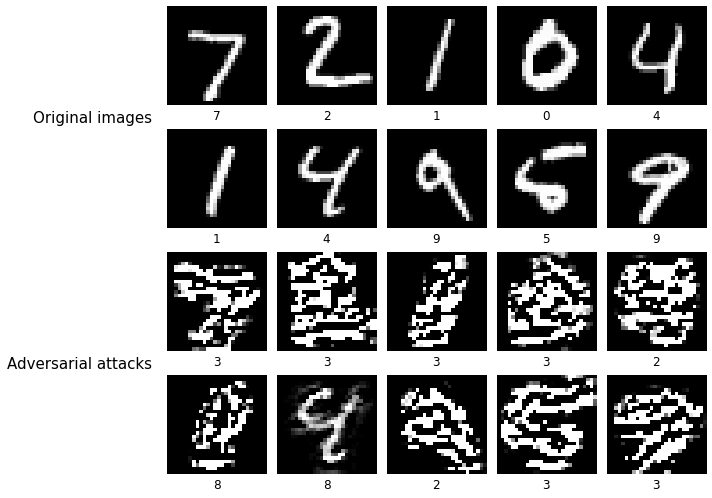

In [248]:
# Plot images before and after adversarial attack
plt.figure(figsize=(10,10))

for i in range(10):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(x_test_cln[i], cmap='gray')
    ax.set_xlabel('{:}'.format(np.argmax(y_test_cln,axis=1)[i]), fontsize=12)
    
    ax = plt.subplot(4, 5, i + 11)
    plt.imshow(x_test_adv[i], cmap='gray')
    ax.set_xlabel('{:}'.format(np.argmax(predictions_adv,axis=1)[i]), fontsize=12)
    
# Plot y-axis labels
ax1 = plt.subplot(4,5,1)
ax1.set_ylabel('Original images', rotation=0, va='center', ha='right', labelpad=15, fontsize=15, y=-0.125)

ax3 = plt.subplot(4,5,11)
ax3.set_ylabel('Adversarial attacks', rotation=0, va='center', ha='right', labelpad=15, fontsize=15, y=-0.125)

# Turn off axis for all plots
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[], frame_on=False)

# Adjusting space between subplots
plt.tight_layout()
plt.subplots_adjust(top=0.7)

# Save and show image
plt.show()

## **Section 2 - Defence**

### **Total Variance Minimization**

Step 1: Transform input

In [249]:
parameter = 0.05
defence = TotalVarMin(lamb=parameter, verbose=True)

In [250]:
x_test_cln_tp_tvm = defence(x_test_cln_tp * 255)[0] / 255
x_test_cln_fp_tvm = defence(x_test_cln_fp * 255)[0] / 255
x_test_cln_tvm = np.concatenate((x_test_cln_tp_tvm, x_test_cln_fp_tvm), axis=0)
y_test_cln_tvm = y_test_cln_tp + y_test_cln_fp

Variance minimization:   0%|          | 0/9911 [00:00<?, ?it/s]

Variance minimization:   0%|          | 0/89 [00:00<?, ?it/s]

In [251]:
x_test_adv_tp_tvm = defence(x_test_adv_tp*255)[0]/255 
x_test_adv_fp_tvm = defence(x_test_adv_fp*255)[0]/255
x_test_adv_tvm = np.concatenate((x_test_adv_tp_tvm, x_test_adv_fp_tvm), axis=0)
y_test_adv_tvm = y_test_adv_tp + y_test_adv_fp

Variance minimization:   0%|          | 0/641 [00:00<?, ?it/s]

Variance minimization:   0%|          | 0/9359 [00:00<?, ?it/s]

Step 2: Evaluate the classifier on all 4 sets of data after TotalVarMin

In [252]:
print('\033[1mThe effect of TotalVarMin:\033[0m\n')

predictions_cln_tvm = classifier.predict(x_test_cln_tvm)
accuracy_cln_tvm = np.sum(np.argmax(predictions_cln_tvm, axis=1) == np.argmax(y_test_cln_tvm, axis=1)) / len(y_test_cln_tvm)

print("On entire \033[1mclean test set\033[0m: {:.2f}%".format((accuracy_cln_tvm - accuracy_cln) * 100))
 
predictions_cln_tp_tvm = classifier.predict(x_test_cln_tp_tvm)
accuracy_cln_tp_tvm = np.sum(np.argmax(predictions_cln_tp_tvm, axis=1) == np.argmax(y_test_cln_tp, axis=1)) / len(y_test_cln_tp)

# print("\nAccuracy on TP clean test examples after TotalVarMin: {:.2f}%".format(accuracy_cln_tp_tvm * 100))
print("\nAccuracy drop on clean TP examples: {:.2f}%".format((1 - accuracy_cln_tp_tvm) * 100))

predictions_cln_fp_tvm = classifier.predict(x_test_cln_fp_tvm)
accuracy_cln_fp_tvm = np.sum(np.argmax(predictions_cln_fp_tvm, axis=1) == np.argmax(y_test_cln_fp, axis=1)) / len(y_test_cln_fp)

print("\nAccuracy increase on clean FP examples: {:.2f}%".format(accuracy_cln_fp_tvm * 100))

predictions_adv_tvm = classifier.predict(x_test_adv_tvm)
accuracy_adv_tvm = np.sum(np.argmax(predictions_adv_tvm, axis=1) == np.argmax(y_test_adv_tvm, axis=1)) / len(y_test_adv_tvm)

print("\nOn entire \033[1madversarial test set\033[0m: +{:.2f}%".format((accuracy_adv_tvm-accuracy_adv) * 100))

predictions_adv_tp_tvm = classifier.predict(x_test_adv_tp_tvm)
accuracy_adv_tp_tvm = np.sum(np.argmax(predictions_adv_tp_tvm, axis=1) == np.argmax(y_test_adv_tp, axis=1)) / len(y_test_adv_tp)

# print("\nAccuracy on TP adversarial test examples after TotalVarMin: {:.2f}%".format(accuracy_adv_tp_tvm * 100))
print("\nAccuracy drop on adversarial TP examples: {:.2f}%".format((1 - accuracy_adv_tp_tvm) * 100))

predictions_adv_fp_tvm = classifier.predict(x_test_adv_fp_tvm)
accuracy_adv_fp_tvm = np.sum(np.argmax(predictions_adv_fp_tvm, axis=1) == np.argmax(y_test_adv_fp, axis=1)) / len(y_test_adv_fp)

print("\nAccuracy increase on adversarial FP examples: {:.2f}%".format(accuracy_adv_fp_tvm * 100))

The effect of TotalVarMin:

On entire clean test set: -0.03%

Accuracy drop on clean TP examples: 0.03%

Accuracy increase on clean FP examples: 0.00%

On entire adversarial test set: +6.66%

Accuracy drop on adversarial TP examples: 47.11%

Accuracy increase on adversarial FP examples: 10.34%


Step 3: Plot all data pre- and post-transformation

In [253]:
# Get index of succetvmful Spatial Smoothing transformations
succ_cln_tp_idx=[]
succ_cln_fp_idx=[]
succ_adv_tp_idx=[]
succ_adv_fp_idx=[]


for k in range(len(predictions_cln_tp_tvm)):
    if(np.argmax(predictions_cln_tp_tvm, axis=1)[k] == np.argmax(y_test_cln_tp, axis=1)[k]):
        succ_cln_tp_idx.append(k)
        
for k in range(len(predictions_cln_fp_tvm)):
    if(np.argmax(predictions_cln_fp_tvm, axis=1)[k] == np.argmax(y_test_cln_fp, axis=1)[k]):
        succ_cln_fp_idx.append(k)
        
for k in range(len(predictions_adv_tp_tvm)):
    if(np.argmax(predictions_adv_tp_tvm, axis=1)[k] == np.argmax(y_test_adv_tp, axis=1)[k]):
        succ_adv_tp_idx.append(k)
        
for k in range(len(predictions_adv_fp_tvm)):
    if(np.argmax(predictions_adv_fp_tvm, axis=1)[k] == np.argmax(y_test_adv_fp, axis=1)[k]):
        succ_adv_fp_idx.append(k)
        
# Get predictions of data before transformation

predictions_cln_tp = classifier.predict(x_test_cln_tp)
predictions_cln_fp = classifier.predict(x_test_cln_fp)
predictions_adv_tp = classifier.predict(x_test_adv_tp)
predictions_adv_fp = classifier.predict(x_test_adv_fp)


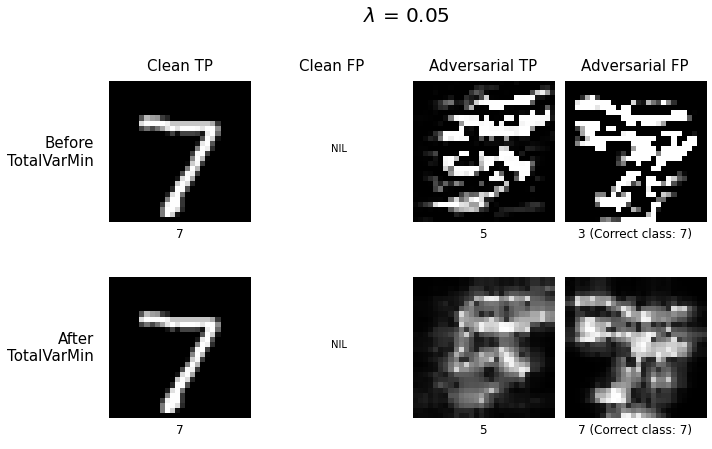

In [255]:
# Plot images before and after TotalVarMin
fig, axs = plt.subplots(2, 4, figsize=(10,10))

# Plot super title
fig.suptitle("$\lambda$ = {:}".format(parameter), y=0.62, x=0.57, fontsize=20)
                     
# Plot x-axis labels
axs[0,0].set_title('Clean TP', va='center', ha='center', pad=15, fontsize=15)
axs[0,1].set_title('Clean FP', va='center', ha='center', pad=15, fontsize=15) #, y = 0.875)
axs[0,2].set_title('Adversarial TP', va='center', ha='center', pad=15, fontsize=15)
axs[0,3].set_title('Adversarial FP', va='center', ha='center', pad=15, fontsize=15)

# Plot y-axis labels
axs[0,0].set_ylabel('Before\nTotalVarMin', rotation=0, va='center', ha='right', labelpad=15, fontsize=15)
axs[1,0].set_ylabel('After\nTotalVarMin', rotation=0, va='center', ha='right', labelpad=15, fontsize=15)

# Plot clean true positives
axs[0,0].imshow(x_test_cln_tp[succ_cln_tp_idx[0]], cmap='gray')
axs[0,0].set_xlabel('{:}'.format(np.argmax(predictions_cln_tp,axis=1)[succ_cln_tp_idx[0]]), labelpad=5, fontsize=12)

axs[1,0].imshow(x_test_cln_tp_tvm[succ_cln_tp_idx[0]], cmap='gray')
axs[1,0].set_xlabel('{:}'.format(np.argmax(predictions_cln_tp_tvm,axis=1)[succ_cln_tp_idx[0]]), labelpad=5, fontsize=12)

# Plot clean false positives
# axs[0,1].text(0.5, 0.5, 'NIL')
axs[0,1].imshow(x_test_cln_fp[succ_cln_fp_idx[0]], cmap='gray')
axs[0,1].set_xlabel('{:} (Correct class: {:})'.format(np.argmax(predictions_cln_fp,axis=1)[succ_cln_fp_idx[0]], np.argmax(y_test_cln_fp,axis=1)[succ_cln_fp_idx[0]]), labelpad=5, fontsize=12)

# axs[1,1].text(0.5, 0.5, 'NIL')
axs[1,1].imshow(x_test_cln_fp_tvm[succ_cln_fp_idx[0]], cmap='gray')
axs[1,1].set_xlabel('{:} (Correct class: {:})'.format(np.argmax(predictions_cln_fp_tvm,axis=1)[succ_cln_fp_idx[0]], np.argmax(y_test_cln_fp,axis=1)[succ_cln_fp_idx[0]]), labelpad=5, fontsize=12)

# Plot adversarial true positives
axs[0,2].imshow(x_test_adv_tp[succ_adv_tp_idx[0]], cmap='gray')
axs[0,2].set_xlabel('{:}'.format(np.argmax(predictions_adv_tp,axis=1)[succ_adv_tp_idx[0]]), labelpad=5, fontsize=12)

axs[1,2].imshow(x_test_adv_tp_tvm[succ_adv_tp_idx[0]], cmap='gray')
axs[1,2].set_xlabel('{:}'.format(np.argmax(predictions_adv_tp_tvm,axis=1)[succ_adv_tp_idx[0]]), labelpad=5, fontsize=12)

# Plot adversarial false positivies
axs[0,3].imshow(x_test_adv_fp[succ_adv_fp_idx[0]], cmap='gray')
axs[0,3].set_xlabel('{:} (Correct class: {:})'.format(np.argmax(predictions_adv_fp,axis=1)[succ_adv_fp_idx[0]], np.argmax(y_test_adv_fp,axis=1)[succ_adv_fp_idx[0]]), labelpad=5, fontsize=12)

axs[1,3].imshow(x_test_adv_fp_tvm[succ_adv_fp_idx[0]], cmap='gray')
axs[1,3].set_xlabel('{:} (Correct class: {:})'.format(np.argmax(predictions_adv_fp_tvm,axis=1)[succ_adv_fp_idx[0]], np.argmax(y_test_adv_fp,axis=1)[succ_adv_fp_idx[0]]), labelpad=5, fontsize=12)

# Turn off axis for all plots
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[], frame_on=False)

# Adjusting space between subplots
plt.tight_layout()
fig.subplots_adjust(top=0.6)
# fig.subplots_adjust(top=0.55)

# Save and show image
# image_path = '/home/cyber/Desktop/Adrian/Plots/TotalVarMin/TotalVarMin_Lambda={:}_MNIST_{:}.png'.format(parameter, attack_name)
image_path = '/Users/Adrian/Downloads/Sem 3.2/TotalVarMin/TotalVarMin_Lambda={:}_MNIST_{:}.png'.format(parameter, attack_name)
plt.savefig(image_path, dpi=500, transparent=True, bbox_inches='tight')
plt.show()

## Others

In [6]:
%store -r x_test_BIM_MNIST
%store -r x_test_JSMA_MNIST
%store -r x_test_Deep_MNIST
%store -r x_test_Newton_MNIST
%store -r x_test_PGD_MNIST

predictions_cln = classifier.predict(x_test_cln)
predictions_jsma = classifier.predict(x_test_JSMA_MNIST)
predictions_bim = classifier.predict(x_test_BIM_MNIST)
predictions_deep = classifier.predict(x_test_Deep_MNIST)
predictions_newton = classifier.predict(x_test_Newton_MNIST)
predictions_pgd = classifier.predict(x_test_PGD_MNIST)

/home/cyber/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [7]:
from art.defences.preprocessor import TotalVarMin

tvm = TotalVarMin(lamb=0.1, verbose=True)
cln_tvm1 = tvm(x_test_cln)[0]
jsma_tvm1 = tvm(x_test_JSMA_MNIST)[0]
bim_tvm1 = tvm(x_test_BIM_MNIST)[0]
deep_tvm1 = tvm(x_test_Deep_MNIST)[0]
newton_tvm1 = tvm(x_test_Newton_MNIST)[0]
pgd_tvm1 = tvm(x_test_PGD_MNIST)[0]


tvm = TotalVarMin(lamb=0.5, verbose=True)
cln_tvm5 = tvm(x_test_cln)[0]
jsma_tvm5 = tvm(x_test_JSMA_MNIST)[0]
bim_tvm5 = tvm(x_test_BIM_MNIST)[0]
deep_tvm5 = tvm(x_test_Deep_MNIST)[0]
newton_tvm5 = tvm(x_test_Newton_MNIST)[0]
pgd_tvm5 = tvm(x_test_PGD_MNIST)[0]

predictions_cln_tvm1 = classifier.predict(cln_tvm1)
predictions_jsma_tvm1 = classifier.predict(jsma_tvm1)
predictions_bim_tvm1 = classifier.predict(bim_tvm1)
predictions_deep_tvm1 = classifier.predict(deep_tvm1)
predictions_newton_tvm1 = classifier.predict(newton_tvm1)
predictions_pgd_tvm1 = classifier.predict(pgd_tvm1)

predictions_cln_tvm5 = classifier.predict(cln_tvm5)
predictions_jsma_tvm5 = classifier.predict(jsma_tvm5)
predictions_bim_tvm5 = classifier.predict(bim_tvm5)
predictions_deep_tvm5 = classifier.predict(deep_tvm5)
predictions_newton_tvm5 = classifier.predict(newton_tvm5)
predictions_pgd_tvm5 = classifier.predict(pgd_tvm5)

Variance minimization:   0%|          | 0/10000 [00:00<?, ?it/s]

Variance minimization:   0%|          | 0/10000 [00:00<?, ?it/s]

Variance minimization:   0%|          | 0/10000 [00:00<?, ?it/s]

Variance minimization:   0%|          | 0/10000 [00:00<?, ?it/s]

Variance minimization:   0%|          | 0/100 [00:00<?, ?it/s]

Variance minimization:   0%|          | 0/10000 [00:00<?, ?it/s]

Variance minimization:   0%|          | 0/10000 [00:00<?, ?it/s]

Variance minimization:   0%|          | 0/10000 [00:00<?, ?it/s]

Variance minimization:   0%|          | 0/10000 [00:00<?, ?it/s]

Variance minimization:   0%|          | 0/10000 [00:00<?, ?it/s]

Variance minimization:   0%|          | 0/100 [00:00<?, ?it/s]

Variance minimization:   0%|          | 0/10000 [00:00<?, ?it/s]

In [9]:
cln_idx=[]
bim_idx=[]
jsma_idx=[]
deep_idx=[]
newton_idx=[]
pgd_idx=[]

for k in range(len(predictions_bim_tvm1)):
    if(np.argmax(predictions_cln_tvm1, axis=1)[k] == np.argmax(predictions_cln_tvm5, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k]):
        cln_idx.append(k)
        
for k in range(len(predictions_bim_tvm1)):
    if(np.argmax(predictions_bim_tvm1, axis=1)[k] == np.argmax(predictions_bim_tvm5, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k] != np.argmax(predictions_bim, axis=1)[k]):
        bim_idx.append(k)
    
for k in range(len(predictions_jsma_tvm1)):
    if(np.argmax(predictions_jsma_tvm1, axis=1)[k] == np.argmax(predictions_jsma_tvm5, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k] != np.argmax(predictions_jsma, axis=1)[k]):
        jsma_idx.append(k)

for k in range(len(predictions_deep_tvm1)):
    if(np.argmax(predictions_deep_tvm1, axis=1)[k] == np.argmax(predictions_deep_tvm5, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k] != np.argmax(predictions_deep, axis=1)[k]):
        deep_idx.append(k)

for k in range(len(predictions_newton_tvm1)):
    if(np.argmax(predictions_newton_tvm1, axis=1)[k] == np.argmax(predictions_newton_tvm5, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k] != np.argmax(predictions_newton, axis=1)[k]):
        newton_idx.append(k)

for k in range(len(predictions_pgd_tvm1)):
    if(np.argmax(predictions_pgd_tvm1, axis=1)[k] == np.argmax(predictions_pgd_tvm5, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k] != np.argmax(predictions_pgd, axis=1)[k]):
        pgd_idx.append(k)

In [45]:
cln_target = []
bim_target = []
jsma_target = []
deep_target = []
newton_target = []
pgd_target = []

for k in range(len(cln_idx)):
    if np.argmax(predictions_cln,axis=1)[cln_idx[k]]== 7:
        cln_target.append(k)
        
for k in range(len(bim_idx)):
    if np.argmax(predictions_bim,axis=1)[bim_idx[k]]== 7:
        bim_target.append(k)

for k in range(len(jsma_idx)):
    if np.argmax(predictions_jsma,axis=1)[jsma_idx[k]]== 7:
        jsma_target.append(k)

for k in range(len(deep_idx)):
    if np.argmax(predictions_deep,axis=1)[deep_idx[k]]== 7:
        deep_target.append(k)
        
for k in range(len(newton_idx)):
    if np.argmax(predictions_newton,axis=1)[newton_idx[k]]== 7:
        newton_target.append(k)
        
for k in range(len(pgd_idx)):
    if np.argmax(predictions_pgd,axis=1)[pgd_idx[k]]== 7:
        pgd_target.append(k)

In [85]:
cln = cln_idx[cln_target[0]] 
bim = bim_idx[bim_target[199]] 
jsma = jsma_idx[jsma_target[51]] 
deep = deep_idx[deep_target[7]] 
newton = newton_idx[newton_target[2]] 
pgd = pgd_idx[pgd_target[6]]

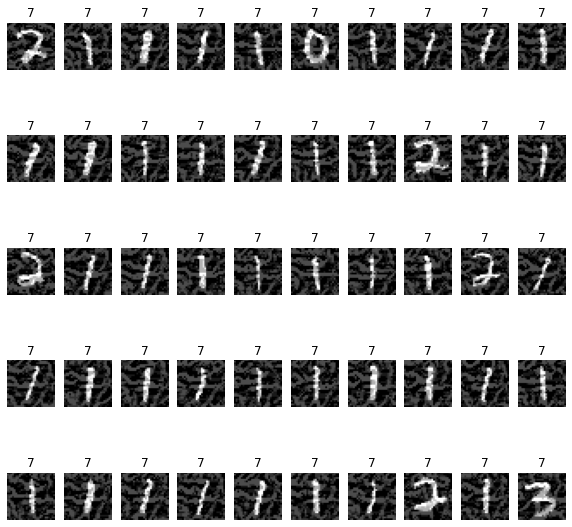

In [84]:
plt.figure(figsize=(10,10))

for i in range (50):
    bim = bim_idx[bim_target[i+150]]
    ax = plt.subplot(5, 10, i+1)
    plt.imshow(x_test_BIM_MNIST[bim], cmap='gray')
    ax.set_title('{:}'.format(np.argmax(predictions_bim,axis=1)[bim]))
    plt.axis("off")

In [48]:
newton_idx

[17, 19, 31, 42, 69, 77, 79, 86, 95]

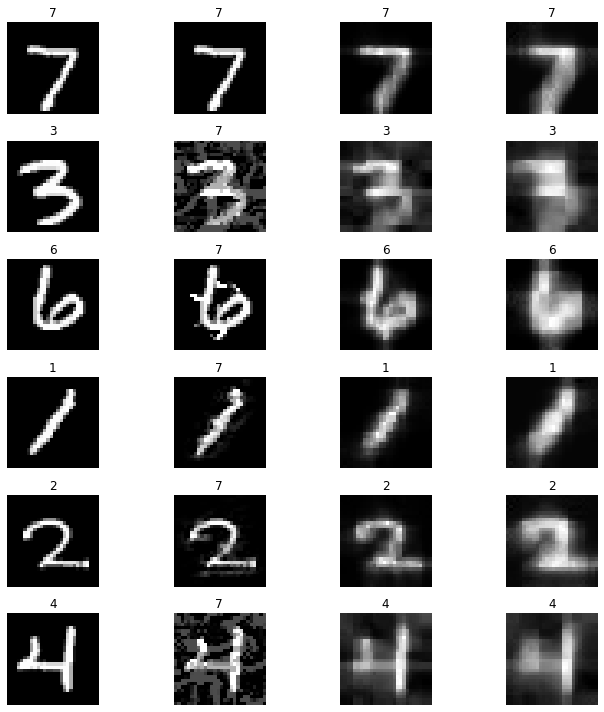

In [86]:
# Plot totalvarmin
plt.figure(figsize=(10,10))

#Plot original image
ax = plt.subplot(6, 4, 1)
plt.imshow(x_test_cln[cln], cmap='gray')
ax.set_title('{:}'.format(np.argmax(y_test_cln,axis=1)[cln]))
plt.axis("off")

ax = plt.subplot(6, 4, 1+4)
plt.imshow(x_test_cln[bim], cmap='gray')
ax.set_title('{:}'.format(np.argmax(y_test_cln,axis=1)[bim]))
plt.axis("off")

ax = plt.subplot(6, 4, 1+8)
plt.imshow(x_test_cln[jsma], cmap='gray')
ax.set_title('{:}'.format(np.argmax(y_test_cln,axis=1)[jsma]))
plt.axis("off")

ax = plt.subplot(6, 4, 1+12)
plt.imshow(x_test_cln[deep], cmap='gray')
ax.set_title('{:}'.format(np.argmax(y_test_cln,axis=1)[deep]))
plt.axis("off")

ax = plt.subplot(6, 4, 1+16)
plt.imshow(x_test_cln[newton], cmap='gray')
ax.set_title('{:}'.format(np.argmax(y_test_cln,axis=1)[newton]))
plt.axis("off")

ax = plt.subplot(6, 4, 1+20)
plt.imshow(x_test_cln[pgd], cmap='gray')
ax.set_title('{:}'.format(np.argmax(y_test_cln,axis=1)[pgd]))
plt.axis("off")

#Plot adversarial examples

ax = plt.subplot(6, 4, 2)
plt.imshow(x_test_cln[cln], cmap='gray')
ax.set_title('{:}'.format(np.argmax(y_test_cln,axis=1)[cln]))
plt.axis("off")

ax = plt.subplot(6, 4, 2+4)
plt.imshow(x_test_BIM_MNIST[bim], cmap='gray')
ax.set_title('{:}'.format(np.argmax(predictions_bim,axis=1)[bim]))
plt.axis("off")

ax = plt.subplot(6, 4, 2+8)
plt.imshow(x_test_JSMA_MNIST[jsma], cmap='gray')
ax.set_title('{:}'.format(np.argmax(predictions_jsma,axis=1)[jsma]))
plt.axis("off")

ax = plt.subplot(6, 4, 2+12)
plt.imshow(x_test_Deep_MNIST[deep], cmap='gray')
ax.set_title('{:}'.format(np.argmax(predictions_deep,axis=1)[deep]))
plt.axis("off")

ax = plt.subplot(6, 4, 2+16)
plt.imshow(x_test_Newton_MNIST[newton], cmap='gray')
ax.set_title('{:}'.format(np.argmax(predictions_newton,axis=1)[newton]))
plt.axis("off")

ax = plt.subplot(6, 4, 2+20)
plt.imshow(x_test_PGD_MNIST[pgd], cmap='gray')
ax.set_title('{:}'.format(np.argmax(predictions_pgd,axis=1)[pgd]))
plt.axis("off")

#Plot totalvarmin lambda=0.1
ax = plt.subplot(6, 4, 3)
plt.imshow(cln_tvm1[cln], cmap='gray')
ax.set_title('{:}'.format(np.argmax(predictions_cln_tvm1,axis=1)[cln]))
plt.axis("off")

ax = plt.subplot(6, 4, 3+4)
plt.imshow(bim_tvm1[bim], cmap='gray')
ax.set_title('{:}'.format(np.argmax(predictions_bim_tvm1,axis=1)[bim]))
plt.axis("off")

ax = plt.subplot(6, 4, 3+8)
plt.imshow(jsma_tvm1[jsma], cmap='gray')
ax.set_title('{:}'.format(np.argmax(predictions_jsma_tvm1,axis=1)[jsma]))
plt.axis("off")

ax = plt.subplot(6, 4, 3+12)
plt.imshow(deep_tvm1[deep], cmap='gray')
ax.set_title('{:}'.format(np.argmax(predictions_deep_tvm1,axis=1)[deep]))
plt.axis("off")

ax = plt.subplot(6, 4, 3+16)
plt.imshow(newton_tvm1[newton], cmap='gray')
ax.set_title('{:}'.format(np.argmax(predictions_newton_tvm1,axis=1)[newton]))
plt.axis("off")

ax = plt.subplot(6, 4, 3+20)
plt.imshow(pgd_tvm1[pgd], cmap='gray')
ax.set_title('{:}'.format(np.argmax(predictions_pgd_tvm1,axis=1)[pgd]))
plt.axis("off")

#Plot totalvarmin lambda=0.5
ax = plt.subplot(6, 4, 4)
plt.imshow(cln_tvm5[cln], cmap='gray')
ax.set_title('{:}'.format(np.argmax(predictions_cln_tvm5,axis=1)[cln]))
plt.axis("off")

ax = plt.subplot(6, 4, 4+4)
plt.imshow(bim_tvm5[bim], cmap='gray')
ax.set_title('{:}'.format(np.argmax(predictions_bim_tvm5,axis=1)[bim]))
plt.axis("off")

ax = plt.subplot(6, 4, 4+8)
plt.imshow(jsma_tvm5[jsma], cmap='gray')
ax.set_title('{:}'.format(np.argmax(predictions_jsma_tvm5,axis=1)[jsma]))
plt.axis("off")

ax = plt.subplot(6, 4, 4+12)
plt.imshow(deep_tvm5[deep], cmap='gray')
ax.set_title('{:}'.format(np.argmax(predictions_deep_tvm5,axis=1)[deep]))
plt.axis("off")

ax = plt.subplot(6, 4, 4+16)
plt.imshow(newton_tvm5[newton], cmap='gray')
ax.set_title('{:}'.format(np.argmax(predictions_newton_tvm5,axis=1)[newton]))
plt.axis("off")

ax = plt.subplot(6, 4, 4+20)
plt.imshow(pgd_tvm5[pgd], cmap='gray')
ax.set_title('{:}'.format(np.argmax(predictions_pgd_tvm5,axis=1)[pgd]))
plt.axis("off")
            

image_path = '/home/cyber/Desktop/Adrian/Plots/TotalVarMin_MNIST_reference (horizontal).png'
plt.savefig(image_path, dpi=500, transparent=True)                       
plt.tight_layout()
plt.show()